In [20]:
%matplotlib inline

from pycocotools.coco import COCO
from PIL import Image, ExifTags
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
# from tensorflow.python import keras

import colorsys
import json
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import pandas as pd
import matplotlib.pyplot as plt
# matplotlib.use('TkAgg')
import tensorflow as tf


# Data

## Basic Information of Data Set

In [21]:
# Load dataset 
dataset_path = os.path.join('TACO', 'data')
anns_file_path = os.path.join(dataset_path, 'annotations.json')

In [22]:
# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
annotations = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(annotations)
nr_images = len(imgs)

In [24]:
# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
last_super_cat_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name']) 
    super_cat_name = cat_it['supercategory']
    
    # Adding new supercat
    if super_cat_name != last_super_cat_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        last_super_cat_name = super_cat_name
        nr_super_cats += 1

In [25]:
print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


## Process Images

The data set contain some images that require rotation, the information can be proceed from the Exif. 

In [26]:
orientation_code = 0
num_difference = 1

# Check if the orientation code in Exif of all images are the same 
for img in imgs:
    image_file_path = os.path.join(dataset_path, img['file_name']).replace('/', '\\')
    image = Image.open(image_file_path)

    if image._getexif():
        exif = dict(image._getexif().items())

    # Obtain Exif orientation tag code
    for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation] == 'Orientation':
            break
    
    if orientation != orientation_code:
        if num_difference == 1:
            orientation_code = orientation
        else:
            print("The orientation_codes are different across all images")
            break

print("The orientation_code is: ", orientation_code)

The orientation_code is:  274


In [27]:
# Loads dataset as a coco object
coco = COCO(anns_file_path)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [28]:
def exif_orientation_to_rotations(img_file_path, orientation_code=orientation_code):
    image = Image.open(img_file_path)
    
    try:
        if image._getexif():
            exif = dict(image._getexif().items())
        
        if orientation_code in exif:
            orientation = exif[orientation_code]
            if orientation == 3:
                return 2  # 180 degrees rotation
            elif orientation == 6:
                return 3  # 270 degrees rotation (or 90 degrees counter-clockwise)
            elif orientation == 8:
                return 1  # 90 degrees rotation
        return 0  # No rotation
    except:
        return 0

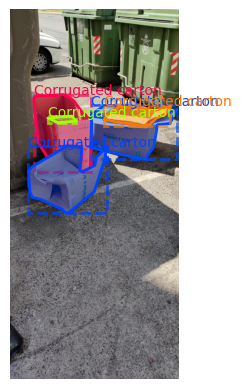

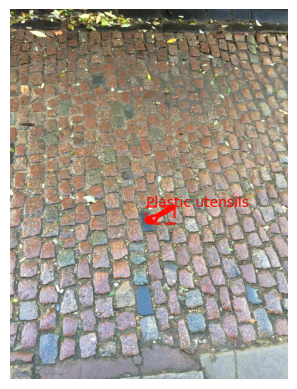

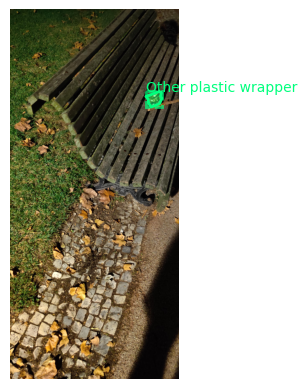

In [31]:
import random

for index in range(3):
    # Choose random images from the imgs
    i = random.randrange(0, nr_images - 1)

    img = imgs[i]
    img_id = img['id']
    img_file_name = img['file_name']
    img_file_path = os.path.join(dataset_path, img_file_name)
    
    I = Image.open(img_file_path)

    k = exif_orientation_to_rotations(img_file_path)
    I = I.rotate(90 * k, expand=True)
    
    # Show image
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    # Load mask ids
    annIds = coco.getAnnIds(imgIds=img_id, catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)
    
    # Show annotations
    for ann in anns_sel:
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)
        
        for seg in ann['segmentation']:
            poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
            p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
            ax.add_collection(p)
            p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
            ax.add_collection(p)
        
        [x, y, w, h] = ann['bbox']
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)
        
        cat = coco.loadCats(ann['category_id'])[0]
        ax.annotate(cat['name'], (x, y), color=color)

    plt.show()

In [32]:
# Model requirement parameters
num_classes = nr_cats
width = 256
height = 256

In [33]:
images = []
bboxes = []
labels = []
scales = []
rotations = []

for ann in annotations:
    img_info = coco.loadImgs(ann["image_id"])[0]
    image_file_path = os.path.join(dataset_path, img_info['file_name']).replace('/', '\\')
    images.append(image_file_path)

    rotation = exif_orientation_to_rotations(image_file_path)
    rotations.append(rotation)

    img_width = img_info['width']
    img_height = img_info['height']
    scale_x = width / img_width
    scale_y = height / img_height
    scales.append([scale_x, scale_y])
    
    bboxes.append(ann['bbox'])

    cat_info = coco.loadCats(ann['category_id'])[0]
    labels.append(cat_info['name'])

# Provide index for lables 
label_map = {label: idx for idx, label in enumerate(cat_names)}

In [34]:
def load_and_process_image(image_path, bbox, label, scale, num_rotations):
    """ Image """
    # Load the image
    image_data = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_data, channels=3)
    
    # Apply EXIF rotation using tf.image.rot90
    image = tf.image.rot90(image, k=num_rotations)

    # Resize the image
    image = tf.image.resize(image, [height, width])
    image = image / 255.0  # Normalize the image to [0, 1]

    ''' Bounding Box '''
    x, y, w, h = bbox
    scale_x, scale_y = scale

    # Adjust x, y, w, h based on the scaling factors
    x = x * scale_x
    y = y * scale_y
    w = w * scale_x
    h = h * scale_y

    # x1, y1 = x - w/2, y - h/2
    # x2, y2 = x + w/2, y + h/2
    
    norm_x = x 
    norm_y = y
    norm_w = w / width
    norm_h = h / height

    norm_bbox = [norm_x, norm_y, norm_w, norm_h]

    ''' Label '''
    # Convert string label to integer using label_map
    label_index = label_map[label.numpy().decode('utf-8')]  # Decode bytes to string and map to integer

    # Apply one-hot encoding
    one_hot_label = tf.one_hot(label_index, num_classes)
    
    return image, norm_bbox, one_hot_label

Check `load_and_process_image` function. 

Processed Image Shape: (256, 256, 3)
Processed BBox: [180.12307692307692, 53.90769230769231, 0.2951923076923077, 0.3314102564102564]
Processed Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


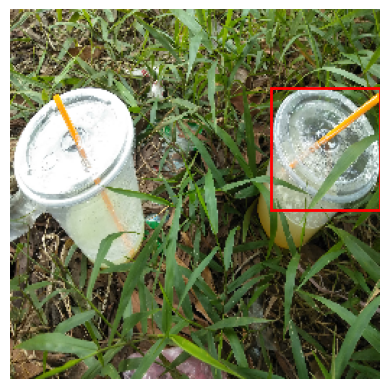

In [37]:
# Choose random images from the imgs
i = random.randrange(0, nr_annotations - 1)

test_image = images[i]
test_bbox = bboxes[i]
test_label = tf.constant(labels[i], dtype=tf.string)
test_scale = scales[i]
test_rotation = rotations[i]

# Call the function
processed_image, processed_bbox, processed_label = load_and_process_image(test_image, test_bbox, test_label, test_scale, test_rotation)

# Print outputs to verify
print("Processed Image Shape:", processed_image.shape)
print("Processed BBox:", processed_bbox)
print("Processed Label:", processed_label.numpy())  # Convert to NumPy to view

# Plot the processed image
plt.imshow(processed_image.numpy())
plt.axis('off')

# Overlay the bounding box
x, y, w, h = processed_bbox
plt.gca().add_patch(plt.Rectangle((x, y), w*width, h*height, edgecolor='red', facecolor='none', lw=2))

# Show the plot
plt.show()

In [38]:
def tf_dataset(images, bboxes, labels, scales, rotations, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices((images, bboxes, labels, scales, rotations))

    # Parse dataset
    ds = ds.map(lambda img, bbox, label, scale, rotation: tf.py_function(
        func=load_and_process_image,
        inp=[img, bbox, label, scale, rotation],
        Tout=[tf.float32, tf.float32, tf.float32]
    ))

    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.cache().batch(batch_size).prefetch(AUTOTUNE)

    return ds

In [39]:
import math

split = math.floor(0.8*len(images))
print("80% split in images is: ", split)

80% split in images is:  3827


In [40]:
train_ds = tf_dataset(images[:split], bboxes[:split], labels[:split], scales[:split], rotations[:split])
valid_ds = tf_dataset(images[split:], bboxes[split:], labels[split:], scales[split:], rotations[split:])

In [50]:
# Function to visualize a batch of images
def visualize_batch(dataset, batch_index=0, num_images=5):
    # Get a batch of images
    for batch_images, batch_bboxes, batch_labels in dataset.skip(batch_index).take(1):
        print(batch_images.shape)  # (batch_size, height, width, 3)
        print(batch_bboxes.shape)  # (batch_size, 4)
        print(batch_labels.shape)  # (batch_size, num_classes)

        # Convert tensors to numpy arrays
        batch_images = batch_images.numpy()
        batch_bboxes = batch_bboxes.numpy()
        batch_labels = batch_labels.numpy()
        
        # Plot the images with bounding boxes and labels
        plt.figure(figsize=(15, 10))
        for index in range(min(num_images, batch_images.shape[0])):
            i = random.randrange(0, batch_images.shape[0] - 1)
            image = batch_images[i]
            bbox = batch_bboxes[i]
            label = np.argmax(batch_labels[i])  # Convert one-hot encoding to label index

            plt.subplot(1, num_images, index + 1)
            plt.imshow(image)
            plt.axis('off')

            # Draw bounding box
            x, y, w, h = bbox
            plt.gca().add_patch(plt.Rectangle((x, y), w*width, h*height, edgecolor='red', facecolor='none', lw=2))
            plt.title(f'Label: {label}')

        plt.show()


(32, 256, 256, 3)
(32, 4)
(32, 60)


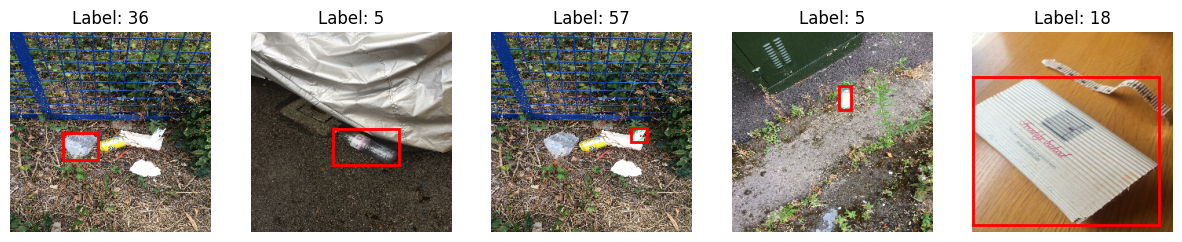

In [52]:
# Visualize the first batch
visualize_batch(train_ds)